In [1]:
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np # linear algebra
import pandas as pd
from tensorflow import keras
from tensorflow.keras import preprocessing
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# import segmentation_models as sm

In [2]:
dataset1 = keras.utils.image_dataset_from_directory(directory="/kaggle/input/photo-reconstruction/Dataset/Training_Data/Cat/Masked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)
dataset2 = keras.utils.image_dataset_from_directory(directory="/kaggle/input/photo-reconstruction/Dataset/Training_Data/Cat/Unmasked_Train", batch_size=1, image_size=[256, 256], labels="inferred", label_mode=None, shuffle=False)

Found 1750 files belonging to 1 classes.
Found 1750 files belonging to 1 classes.


In [3]:
dataset = tf.data.Dataset.zip((dataset1, dataset2))

In [4]:
train_size = int(0.8*dataset.cardinality().numpy())

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [5]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(normalize, num_parallel_calls=AUTOTUNE)

In [7]:
AUTOTUNE

-1

In [8]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [9]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


In [11]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


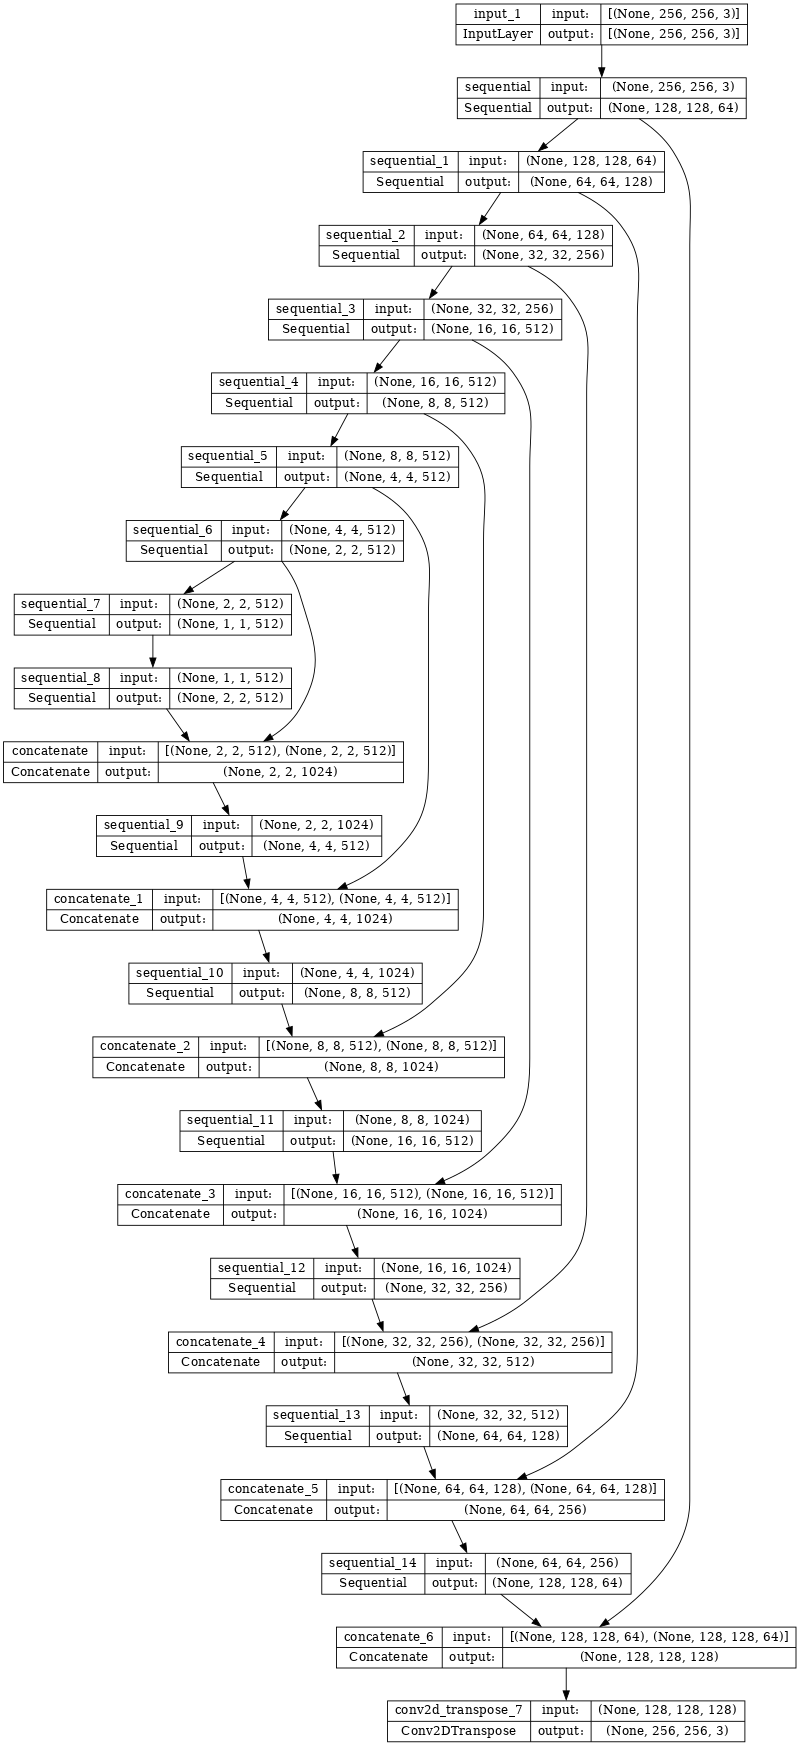

In [12]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


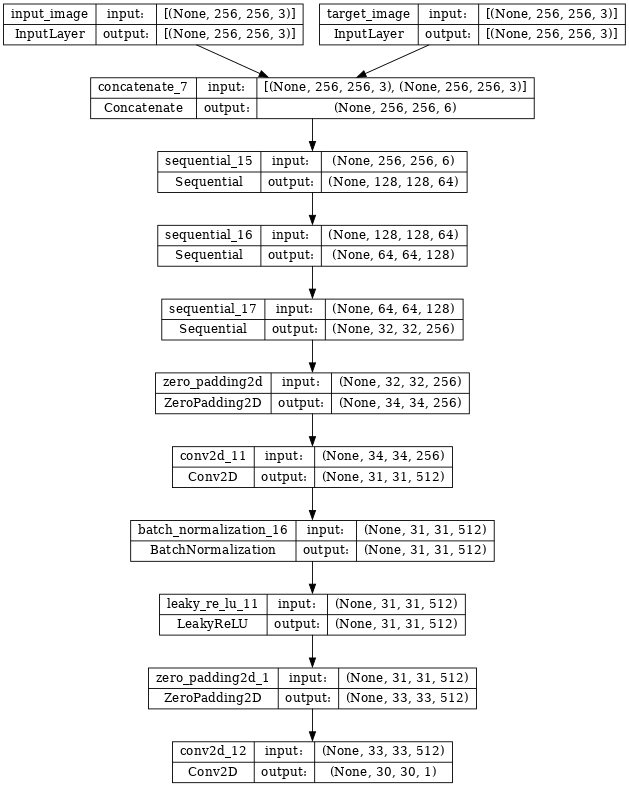

In [14]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [15]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [16]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [17]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
#     plt.figure(figsize=(15, 15))

#     display_list = [test_input[0], tar[0], prediction[0]]
#     title = ['Input Image', 'Ground Truth', 'Predicted Image']

#     for i in range(3):
#         plt.subplot(1, 3, i+1)
#         plt.title(title[i])
#         # Getting the pixel values in the [0, 1] range to plot.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
#         plt.axis('off')
#     plt.show()
    return prediction[0]


In [19]:
for example_input, example_target in train_dataset.take(1):
    print(example_input.shape)
    print(type(example_input))
    generate_images(generator, example_input, example_target)


(1, 256, 256, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [20]:
@tf.function
def train_step(input_image, target, step):
    print(step)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [21]:
LAMBDA = 100

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [24]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")
        
        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
#         if (step + 1) % 5000 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

In [25]:
log_dir="logs/"
import datetime
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

import os

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
import time
import os
import pathlib
import time     
import datetime

from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output
fit(train_dataset, val_dataset, steps=150000)

Time taken for 1000 steps: 52.89 sec

Step: 149k
....................................................................................................

In [28]:
def read_test_data(filepath):
    test_imgs_path = []
    masked_info_path=[]
    for filename in os.listdir(filepath):
        final_path = filepath+'/'+filename
        if filename != 'masked_info.csv':
            test_imgs_path.append(final_path)
        else:
            masked_info_path.append(final_path)
    return test_imgs_path,masked_info_path

In [29]:
test_filepath = '/kaggle/input/photo-reconstruction/Dataset/Testing_Data'
test_imgs_path,masked_info_path = read_test_data(test_filepath)

In [30]:
print(len(test_imgs_path))

200


In [31]:
test_imgs_path[0]

'/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Dog-Train (411).jpeg'

In [32]:
def give_images(paths):
    images=[]
    for path in paths:
        img = Image.open(path)
        rgb_pixels = np.array(img)
        images.append((rgb_pixels - 127.5)/127.5)
    return images

In [33]:
type(example_input)

tensorflow.python.framework.ops.EagerTensor

In [34]:
example_input.shape

TensorShape([1, 256, 256, 3])

In [35]:
result_path = '/kaggle/input/masked-info/'
batch_size = 1
output_images = []
i = 1
for start,end in zip(range(0, len(test_imgs_path)+1, batch_size),range(batch_size, len(test_imgs_path)+1, batch_size)):
    imgs_path = test_imgs_path[start:end]
    print(imgs_path[0])
    image = give_images(imgs_path)
    image[0] = image[0].reshape((1, 256, 256, 3))
    print(image[0].shape)
    print(type(image[0]))
    imgs = generate_images(generator, image[0], example_target)
#     imgs = give_images(imgs_path)

    print(np.array(imgs).shape,'----')
#     reconstruction_vals = sess.run(reconstruction,
#         feed_dict={
#                images_tf: imgs,
#                is_train: False
#                })
        
    print(imgs.shape)
    print(i) 
    i += 1
    output_images.append(imgs)

/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Dog-Train (411).jpeg
(1, 256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3) ----
(256, 256, 3)
1
/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Cat-Train (923).jpeg
(1, 256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3) ----
(256, 256, 3)
2
/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Elephant-Train (1916).jpeg
(1, 256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3) ----
(256, 256, 3)
3
/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Elephant-Train (607).jpeg
(1, 256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3) ----
(256, 256, 3)
4
/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Tiger (1003).jpeg
(1, 256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3) ----
(256, 256, 3)
5
/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Elephant-Train (1195).jpeg
(1, 256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3) ----
(256, 256, 3)
6
/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Cat-Train (7

In [36]:
test_images_filename = [img.split('/')[-1] for img in test_imgs_path]

In [37]:
mask_info = pd.read_csv(masked_info_path[0],usecols=[1,2,3,4,5]).set_index('filename').reindex(test_images_filename)

In [38]:
test_images_filename[0]

'Dog-Train (411).jpeg'

In [39]:
mask_info.shape

(200, 4)

In [40]:
len(output_images)

200

In [41]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [42]:
type(output_images[0])

tensorflow.python.framework.ops.EagerTensor

In [43]:
output_images[0].shape

TensorShape([256, 256, 3])

In [44]:
filename=[]
value=[]
iters = mask_info.shape[0]
i=0
while i < iters  :
    img = (255. * (output_images[i].numpy() + 1)/2.).astype(int)
    ind = mask_info.index[i]
    row1=int(mask_info.loc[ind,'box1_row'])
    col1=int(mask_info.loc[ind,'box1_col'])
    row2=int(mask_info.loc[ind,'box2_row'])
    col2=int(mask_info.loc[ind,'box2_col'])
    temp1=test_images_filename[i]+'_box1_'
    temp2=test_images_filename[i]+'_box2_'
    for r in range(row1,row1+75):
        for c in range(col1,col1+75):
            for channel in range(0,3):
                filename.append(temp1+str(r)+'_'+str(c)+'_'+str(channel))
                value.append(img[r,c,channel]/255)
    for r in range(row2,row2+75):
        for c in range(col2,col2+75):
            for channel in range(0,3):
                filename.append(temp2+str(r)+'_'+str(c)+'_'+str(channel))
                value.append(img[r,c,channel]/255)
    i+=1
    
    

In [45]:
len(filename)

6750000

In [46]:
output_df = pd.DataFrame(list(zip(filename, value)), columns=['filename_box_pixel', 'Value'])

In [47]:
output_df.shape

(6750000, 2)

In [48]:
output_df.to_csv('output_final_v2.csv',index=False)

In [49]:
output_images[0][0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.3634839>

In [50]:
type(1)

int

In [51]:
type(2)

int

In [52]:
type(2)

int